In [1]:
using Pkg 
Pkg.activate("..")

  Activating project at `~/code/PhasorNetworks.jl`


In [2]:
include("../src/PhasorNetworks.jl")
using .PhasorNetworks, Plots, DifferentialEquations

In [3]:
using Lux, MLUtils, MLDatasets, OneHotArrays, Statistics, Test, LuxCUDA
using Random: Xoshiro, AbstractRNG
using Base: @kwdef
using Zygote: withgradient
using Optimisers, ComponentArrays
using Statistics: mean
using LinearAlgebra: diag
using PhasorNetworks: bind
using Distributions: Normal
using DifferentialEquations: Heun, Tsit5

[ Info: Precompiling PhasorNetworks [c32d742c-e486-48f1-8804-9f6fb4d3f42c] (cache misses: include_dependency fsize change (2), mismatched flags (4))
ERROR: Method overwriting is not permitted during Module precompilation. Use `__precompile__(false)` to opt-out of precompilation.
┌ Info: Skipping precompilation due to precompilable error. Importing PhasorNetworks [c32d742c-e486-48f1-8804-9f6fb4d3f42c].
└   exception = Error when precompiling module, potentially caused by a __precompile__(false) declaration in the module.


In [4]:
solver_args = Dict(:adaptive => false, :dt => 0.01)

Dict{Symbol, Real} with 2 entries:
  :adaptive => false
  :dt       => 0.01

In [5]:
spk_args = SpikingArgs(threshold = 0.001,
                    solver=Tsit5(), 
                    solver_args = solver_args)

Neuron parameters: Period 1.0 (s)
Current kernel duration: 0.01 (s)
Threshold: 0.001 (V)


In [6]:
cdev = cpu_device()
gdev = gpu_device()

(::CUDADevice{Nothing, Missing}) (generic function with 1 method)

In [7]:
args = Args(batchsize = 128, epochs = 25, use_cuda = true)

Args(0.0003, 128, 25, true, Xoshiro(0xa379de7eeeb2a4e8, 0x953dccb6b532b3af, 0xf597b8ff8cfd652a, 0xccd7337c571680d1, 0xc90c4a0730db3f7e))

In [8]:
#global args for all tests
n_x = 101
n_y = 101
n_vsa = 1
epsilon = 0.10
repeats = 20
epsilon = 0.025


tspan = (0.0, repeats*1.0)
tbase = collect(tspan[1]:spk_args.solver_args[:dt]:tspan[2]);

In [9]:
include("../test/network_tests.jl")

spiking_accuracy_test (generic function with 1 method)

In [10]:
train_data = MLDatasets.FashionMNIST(split=:train)
test_data = MLDatasets.FashionMNIST(split=:test)

dataset FashionMNIST:
  metadata  =>    Dict{String, Any} with 4 entries
  split     =>    :test
  features  =>    28×28×10000 Array{Float32, 3}
  targets   =>    10000-element Vector{Int64}

In [11]:
train_loader =DataLoader(train_data, batchsize=args.batchsize)

469-element DataLoader(::FashionMNIST, batchsize=128)
  with first element:
  (; features = 28×28×128 Array{Float32, 3}, targets = 128-element Vector{Int64})

In [12]:
test_loader =DataLoader(test_data, batchsize=args.batchsize)

79-element DataLoader(::FashionMNIST, batchsize=128)
  with first element:
  (; features = 28×28×128 Array{Float32, 3}, targets = 128-element Vector{Int64})

In [13]:
x0, y0 = first(train_loader)

(features = Float32[0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0; … ; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0;;; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0; … ; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0;;; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0; … ; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0;;; … ;;; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0; … ; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0;;; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0; … ; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0;;; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0; … ; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0], targets = [9, 0, 0, 3, 0, 2, 7, 2, 5, 5  …  6, 7, 5, 5, 9, 2, 2, 2, 7, 6])

In [14]:
x0 |> size

(28, 28, 128)

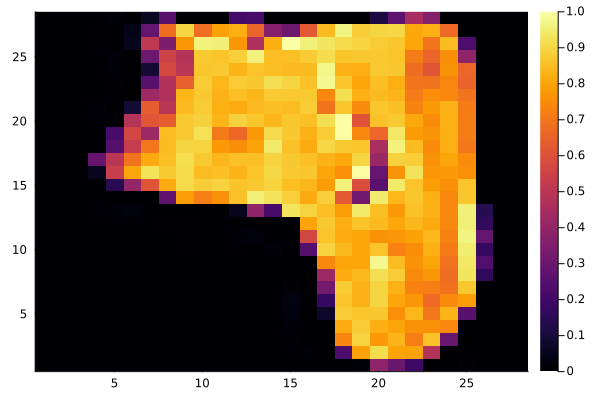

In [15]:
heatmap(x0[:,:,1])

# Test conventional network

In [16]:
construct_model = n -> Chain(FlattenLayer(),
            LayerNorm((28^2,)),
            Dense(28^2 => n, relu),
            Dense(n => 10),
            softmax)

#31 (generic function with 1 method)

In [17]:
model = construct_model(128)

Chain(
    layer_1 = FlattenLayer{Nothing}(nothing),
    layer_2 = LayerNorm((784,), affine=true, dims=Colon()),  # 1_568 parameters
    layer_3 = Dense(784 => 128, relu),            # 100_480 parameters
    layer_4 = Dense(128 => 10),                   # 1_290 parameters
    layer_5 = WrappedFunction(softmax),
)         # Total: 103_338 parameters,
          #        plus 0 states.

In [18]:
ps, st = Lux.setup(args.rng, model)

((layer_1 = NamedTuple(), layer_2 = (bias = Float32[0.0; 0.0; … ; 0.0; 0.0;;], scale = Float32[1.0; 1.0; … ; 1.0; 1.0;;]), layer_3 = (weight = Float32[-0.0112625575 0.09778222 … -0.10101536 0.090369396; -0.080769345 0.06662725 … 0.0866409 -0.091435656; … ; 0.088066004 -0.111865155 … -0.014957014 -0.092328005; 0.049049195 -0.076358505 … 0.005965299 0.0023016678], bias = Float32[0.022867223, -0.005552969, 0.0128062535, 0.016987672, -0.029769417, -0.028511818, -0.034402616, -0.012781019, 0.005802878, 0.033536788  …  0.025755508, 0.0049556494, 0.01800868, -0.015800416, 0.009187677, 0.0042766673, 0.011223478, 0.0118460525, 0.019908717, -0.0135502685]), layer_4 = (weight = Float32[0.113127045 -0.04885875 … -0.03762582 0.08072976; 0.016276116 -0.043997686 … 0.0995841 0.017578097; … ; -0.09091437 -0.020437691 … -0.024808904 0.018207107; 0.0711904 -0.122683704 … -0.13283393 -0.019145327], bias = Float32[-0.031575713, -0.087607525, -0.0455442, 0.051857945, 0.047413476, 0.079458684, 0.08564899, -

In [19]:
yp, _ = model(x0, ps, st);

In [20]:
yp |> size

(10, 128)

In [21]:
function loss_function(x, y, model, ps, st)
    y_pred, _ = Lux.apply(model, x, ps, st)
    y_onehot = onehotbatch(y, 0:9)
    return CrossEntropyLoss(;logits=false, dims=1)(y_pred, y_onehot)
end

loss_function (generic function with 1 method)

In [22]:
loss_function(x0, y0, model, ps, st)

2.8641567f0

In [23]:
losses, pst, stt = train(model, ps |> gdev, st |> gdev, train_loader, loss_function, args)

[ Info: Training on CPU


(Any[2.8641567f0, 2.5659437f0, 2.387064f0, 2.1986299f0, 2.148335f0, 1.8518924f0, 1.7919455f0, 1.6326872f0, 1.6997683f0, 1.5456713f0  …  0.20519409f0, 0.18482399f0, 0.14162587f0, 0.23544107f0, 0.24074218f0, 0.16624248f0, 0.22450583f0, 0.22559026f0, 0.09765837f0, 0.15866928f0], (layer_1 = NamedTuple(), layer_2 = (bias = Float32[0.038406536; 0.017918281; … ; 0.046671223; 0.019242242;;], scale = Float32[0.969162; 0.9840778; … ; 0.9716084; 0.98476076;;]), layer_3 = (weight = Float32[0.0062826984 0.11479646 … -0.08033957 0.10508532; -0.08677065 0.059964977 … 0.0745905 -0.092425995; … ; 0.073537506 -0.12590684 … -0.03909918 -0.11069321; 0.07812478 -0.0465651 … 0.033894457 0.032850184], bias = Float32[0.006977855, 0.0047661057, -0.0036222101, 0.012951335, -0.0019997153, -0.013606623, 0.023555515, 0.011161522, 0.044679105, 0.011207561  …  -0.005677891, -0.011133213, 0.0023209886, 0.019759463, 0.01545383, 0.04544099, 0.01437314, -0.0002253647, 0.03578561, -0.04288651]), layer_4 = (weight = Float

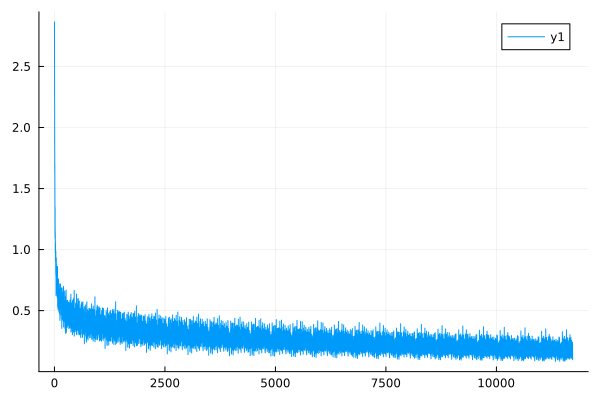

In [24]:
plot(losses)

In [25]:
x1, y1 = first(test_loader)

(features = Float32[0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0; … ; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0;;; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0; … ; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0;;; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0; … ; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0;;; … ;;; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0; … ; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0;;; 0.0 0.0 … 0.003921569 0.0; 0.0 0.0 … 0.0 0.003921569; … ; 0.0 0.0 … 0.0 0.043137256; 0.0 0.0 … 0.0 0.0;;; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0; … ; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0], targets = [9, 2, 1, 1, 6, 1, 4, 6, 5, 7  …  7, 8, 0, 0, 9, 9, 3, 0, 8, 4])

In [26]:
function test(model, data_loader, ps, st)
    # Evaluation phase
    total_correct = 0
    total_samples = 0
    for (x, y) in data_loader
        x = x |> gdev
        
        y_pred, _ = Lux.apply(model, x, ps, st)
        pred_labels = onecold(cdev(y_pred))
        
        total_correct += sum(pred_labels .== y .+ 1)
        total_samples += length(y)
    end

    acc = total_correct / total_samples
end

test (generic function with 1 method)

In [27]:
test(model, test_loader, ps |> gdev, st |> gdev)

0.0821

In [28]:
test(model, test_loader, pst, stt)

0.8824

In [29]:
function automate_train(n::Integer, e::Integer)
    args = Args(batchsize = 128, epochs = e, use_cuda = true)
    model = construct_model(n)
    ps, st = Lux.setup(args.rng, model)
    losses, pst, stt = train(model, ps |> gdev, st |> gdev, train_loader, loss_function, args)
    final_loss = losses[end]
    accuracy = test(model, test_loader, pst, stt)

    return accuracy, final_loss
end

automate_train (generic function with 1 method)

In [30]:
#automate_train(64, 5)

# Test Phasor network

In [16]:
import .PhasorNetworks: default_bias

In [17]:
p_model = Chain(FlattenLayer(),
            LayerNorm((28^2,)),
            x -> tanh.(x), 
            x -> x,  #placeholder for makespiking
            PhasorDense(28^2 => 128, soft_angle, init_bias=default_bias),
            PhasorDense(128 => 16, soft_angle, init_bias=default_bias),
            Codebook(16 => 10),
            )

Chain(
    layer_1 = FlattenLayer{Nothing}(nothing),
    layer_2 = LayerNorm((784,), affine=true, dims=Colon()),  # 1_568 parameters
    layer_3 = WrappedFunction(#31),
    layer_4 = WrappedFunction(#32),
    layer_5 = PhasorDense(
        layer = Dense(784 => 128, use_bias=false),  # 100_352 parameters
        bias = ComplexBias((128,)),               # 256 parameters
    ),
    layer_6 = PhasorDense(
        layer = Dense(128 => 16, use_bias=false),  # 2_048 parameters
        bias = ComplexBias((16,)),                # 32 parameters
    ),
    layer_7 = Codebook(16 => 10),                 # 160 parameters
)         # Total: 104_416 parameters,
          #        plus 0 states.

In [18]:
psp, stp = Lux.setup(args.rng, p_model, )  .|> gdev

((layer_1 = NamedTuple(), layer_2 = (bias = Float32[0.0; 0.0; … ; 0.0; 0.0;;], scale = Float32[1.0; 1.0; … ; 1.0; 1.0;;]), layer_3 = NamedTuple(), layer_4 = NamedTuple(), layer_5 = (layer = (weight = Float32[-0.0056312787 0.04889111 … -0.05050768 0.045184698; -0.040384673 0.033313625 … 0.04332045 -0.045717828; … ; 0.044033002 -0.055932578 … -0.007478507 -0.046164002; 0.024524597 -0.038179252 … 0.0029826495 0.0011508339],), bias = (bias_real = Float32[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0  …  1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0], bias_imag = Float32[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0  …  0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0])), layer_6 = (layer = (weight = Float32[0.0980228 -0.011076875 … 0.09974359 0.11172987; -0.023803396 0.008978238 … -0.012752984 0.09595233; … ; 0.10593608 -0.04436694 … 0.038488667 -0.13129868; -0.046925623 0.14846596 … -0.10436779 0.07703115],), bias = (bias_real = Float32[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0

In [19]:
yp0, _ = p_model(x0 |> gdev, psp, stp) 

(Float32[0.3249726 0.15033911 … 0.24379177 0.36345112; -0.00803018 -0.20857786 … -0.20066854 -0.10052705; … ; -0.1447365 -0.12096888 … -0.2030021 -0.120892584; 0.054367784 0.10195694 … -0.08109467 0.25317574], (layer_1 = NamedTuple(), layer_2 = NamedTuple(), layer_3 = NamedTuple(), layer_4 = NamedTuple(), layer_5 = (dense = NamedTuple(), bias = NamedTuple()), layer_6 = (dense = NamedTuple(), bias = NamedTuple()), layer_7 = NamedTuple()))

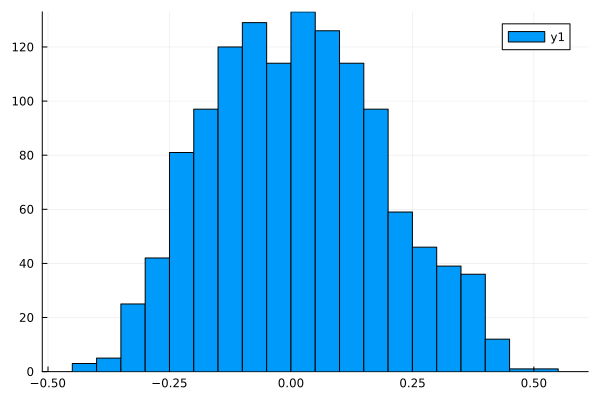

In [20]:
histogram(cdev(vec(yp0)))

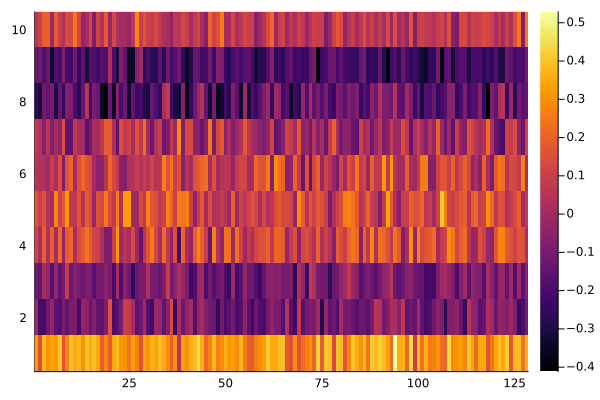

In [21]:
heatmap(cdev(yp0))

In [22]:
size(yp0)

(10, 128)

In [23]:
import .PhasorNetworks: codebook_loss

In [24]:
function codebook_loss(similarities::AbstractArray, truth::AbstractArray; dims=-1)
    if dims == -1
        dims = ndims(similarities)
    end

    prob = softmax(similarities, dims=dims)
    loss = CrossEntropyLoss(;logits=false, dims=dims)(prob, truth)
    
    return loss
end

codebook_loss (generic function with 1 method)

In [25]:
lbl = 1.0f0 .* onehotbatch(y0, 0:9);

In [26]:
yp0 |> size

(10, 128)

In [27]:
codebook_loss(yp0, lbl |> gdev, dims=1)

2.2869658f0

In [28]:
function phasor_loss_function(x, y, model, ps, st)
    y_pred, _ = Lux.apply(model, x, ps, st)
    y_onehot = onehotbatch(y, 0:9)
    loss = codebook_loss(y_pred, y_onehot, dims=1) 
    loss = mean(loss)
    return loss
end

phasor_loss_function (generic function with 1 method)

In [29]:
phasor_loss_function(x0 |> gdev, y0 |> gdev, p_model, psp, stp)

2.2869658f0

In [30]:
losses_f, ps_train_f, st_train_f = train(p_model, psp, stp, train_loader, phasor_loss_function, args, optimiser=RMSProp)

[ Info: Training on CUDA GPU


(Any[2.2869658f0, 2.2377868f0, 2.2181096f0, 2.1776679f0, 2.1761851f0, 2.1374369f0, 2.103044f0, 2.1119795f0, 2.11732f0, 2.0788865f0  …  1.4731362f0, 1.474255f0, 1.4478168f0, 1.4944227f0, 1.4782163f0, 1.474959f0, 1.4809599f0, 1.4855025f0, 1.4514577f0, 1.4740591f0], (layer_1 = NamedTuple(), layer_2 = (bias = Float32[-0.1653413; 0.11516043; … ; 0.17209877; 0.17134377;;], scale = Float32[1.1374032; 0.8827519; … ; 0.8060798; 0.8136192;;]), layer_3 = NamedTuple(), layer_4 = NamedTuple(), layer_5 = (layer = (weight = Float32[0.00046705466 0.082237065 … -0.028661614 0.070637554; -0.010621669 0.079825915 … 0.110913984 0.011607645; … ; 0.02216796 -0.04837512 … 0.012041477 -0.027208975; -4.468856f-5 -0.06967099 … -0.035416633 -0.037204806],), bias = (bias_real = Float32[1.1415356, 0.9773325, 1.0763446, 1.0135485, 1.2587423, 1.0792722, 1.0292512, 1.1674614, 1.0828217, 1.1254828  …  1.2323571, 0.9858826, 1.0844609, 0.977162, 1.0134059, 1.0697851, 1.0021079, 1.0207343, 1.0798498, 1.0043476], bias_ima

In [31]:
ps_train_f.layer_5.bias

(bias_real = Float32[1.1415356, 0.9773325, 1.0763446, 1.0135485, 1.2587423, 1.0792722, 1.0292512, 1.1674614, 1.0828217, 1.1254828  …  1.2323571, 0.9858826, 1.0844609, 0.977162, 1.0134059, 1.0697851, 1.0021079, 1.0207343, 1.0798498, 1.0043476], bias_imag = Float32[-0.0536195, -0.05673856, -0.023508802, -0.019509807, -0.060994465, -0.053000834, -0.14002125, -0.05213011, -0.00986773, -0.031050786  …  -0.023916308, 0.017024336, -0.022620171, 0.12963353, 0.045275185, -0.024704563, 0.0040399646, 0.04283685, -0.0508816, 0.050801236])

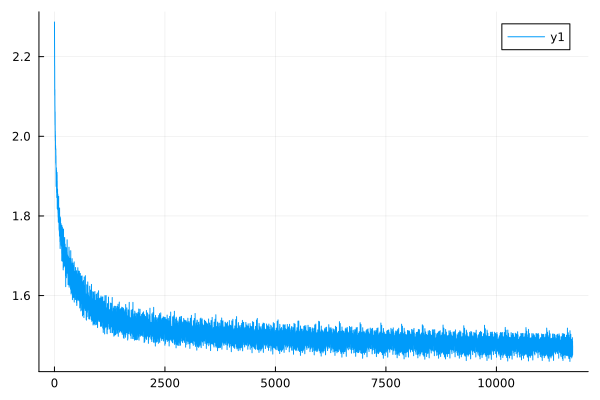

In [32]:
plot(losses_f)

In [33]:
yp1, _ = p_model(x0 |> gdev, ps_train_f, st_train_f) 

(Float32[-0.1597418 0.97999495 … -0.20352772 0.89400095; -0.098223545 -0.10310556 … -0.026885137 -0.26612887; … ; -0.048542336 -0.1589565 … -0.1228544 -0.15526253; 0.99631155 -0.15282829 … 0.21962297 -0.33008766], (layer_1 = NamedTuple(), layer_2 = NamedTuple(), layer_3 = NamedTuple(), layer_4 = NamedTuple(), layer_5 = (dense = NamedTuple(), bias = NamedTuple()), layer_6 = (dense = NamedTuple(), bias = NamedTuple()), layer_7 = NamedTuple()))

In [34]:
size(yp1)

(10, 128)

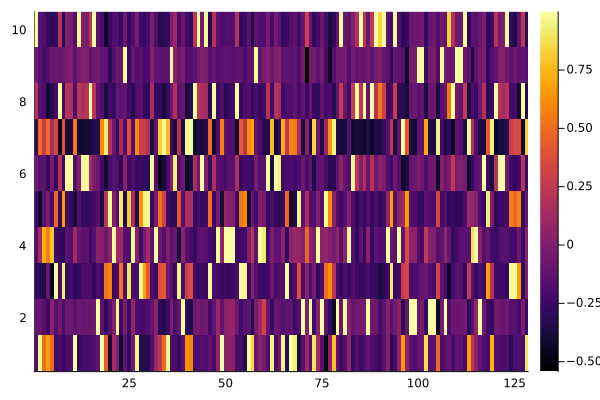

In [35]:
heatmap(cdev(yp1))

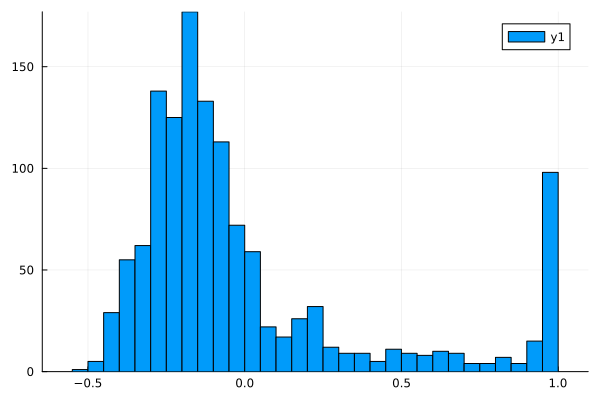

In [36]:
histogram(vec(cdev(yp1)))

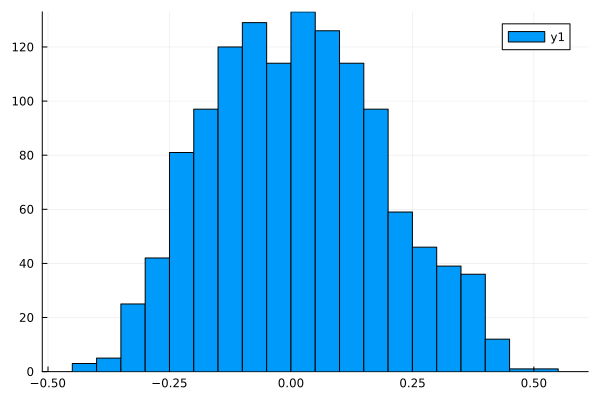

In [37]:
histogram(cdev(vec(yp0)))

In [38]:
function test_phasor(model, data_loader, ps, st)
    # Evaluation phase
    total_correct = 0
    total_samples = 0
    for (x, y) in data_loader
        x = x |> gdev
        
        y_pred, _ = Lux.apply(model, x, ps, st)
        pred_labels = predict_codebook(cdev(y_pred))
        
        total_correct += sum(pred_labels .== y .+ 1)
        total_samples += length(y)
    end

    acc = total_correct / total_samples
end

test_phasor (generic function with 1 method)

In [39]:
test_phasor(p_model, test_loader, ps_train_f, st_train_f)

0.8677

# Test spiking behavior

In [40]:
import .PhasorNetworks: Codebook, LuxParams

In [41]:
spk_model = Chain(FlattenLayer(),
            LayerNorm((28^2,)),
            x -> tanh.(x), 
            MakeSpiking(spk_args, repeats),
            PhasorDense(28^2 => 128, soft_angle, init_bias=default_bias),
            PhasorDense(128 => 16, soft_angle, init_bias=default_bias),
            Codebook(16 => 10),
            )

Chain(
    layer_1 = FlattenLayer{Nothing}(nothing),
    layer_2 = LayerNorm((784,), affine=true, dims=Colon()),  # 1_568 parameters
    layer_3 = WrappedFunction(#36),
    layer_4 = MakeSpiking(Neuron parameters: Period 1.0 (s)
Current kernel duration: 0.01 (s)
Threshold: 0.001 (V)
, 20, (0.0f0, 20.0f0), 0.0f0),
    layer_5 = PhasorDense(
        layer = Dense(784 => 128, use_bias=false),  # 100_352 parameters
        bias = ComplexBias((128,)),               # 256 parameters
    ),
    layer_6 = PhasorDense(
        layer = Dense(128 => 16, use_bias=false),  # 2_048 parameters
        bias = ComplexBias((16,)),                # 32 parameters
    ),
    layer_7 = Codebook(16 => 10),                 # 160 parameters
)         # Total: 104_416 parameters,
          #        plus 0 states.

In [42]:
ps0t, st0t = Lux.setup(args.rng, spk_model) .|> gdev

((layer_1 = NamedTuple(), layer_2 = (bias = Float32[0.0; 0.0; … ; 0.0; 0.0;;], scale = Float32[1.0; 1.0; … ; 1.0; 1.0;;]), layer_3 = NamedTuple(), layer_4 = NamedTuple(), layer_5 = (layer = (weight = Float32[0.0135705015 -0.05729247 … 0.0163186 -0.017677143; -0.0026602584 0.060192093 … 0.051260214 -0.022274366; … ; -0.023816729 -0.012598705 … 0.053770266 0.045829695; -0.053956818 -0.0069056815 … 0.008795149 -0.054133724],), bias = (bias_real = Float32[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0  …  1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0], bias_imag = Float32[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0  …  0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0])), layer_6 = (layer = (weight = Float32[-0.14734356 -0.11203233 … -0.10271278 -0.09439357; -0.051993318 -0.111854024 … -0.08929189 0.04747729; … ; -0.074096166 -0.09537681 … 0.05314868 0.041080713; -0.09813437 -0.06701051 … -0.13512348 0.019357903],), bias = (bias_real = Float32[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.

In [43]:
ys0, _ = spk_model(x0 |> gdev, ps0t , st0t)

(CuArray{Float32, 2, CUDA.DeviceMemory}[[-1.0 -1.0 … -1.0 -1.0; -1.0 -1.0 … -1.0 -1.0; … ; -1.0 -1.0 … -1.0 -1.0; -1.0 -1.0 … -1.0 -1.0], [-0.5 -0.5 … -0.5 -0.5; -0.5 -0.5 … -0.5 -0.5; … ; -0.5 -0.5 … -0.5 -0.5; -0.5 -0.5 … -0.5 -0.5], [-0.5 -0.5 … -0.5 -0.5; -0.5 -0.5 … -0.5 -0.5; … ; -0.5 -0.5 … -0.5 -0.5; -0.5 -0.5 … -0.5 -0.5], [-0.5 -0.5 … -0.5 -0.5; -0.5 -0.5 … -0.5 -0.5; … ; -0.5 -0.5 … -0.5 -0.5; -0.5 -0.5 … -0.5 -0.5], [-0.5 -0.5 … -0.5 -0.5; -0.5 -0.5 … -0.5 -0.5; … ; -0.5 -0.5 … -0.5 -0.5; -0.5 -0.5 … -0.5 -0.5], [-0.5 -0.5 … -0.5 -0.5; -0.5 -0.5 … -0.5 -0.5; … ; -0.5 -0.5 … -0.5 -0.5; -0.5 -0.5 … -0.5 -0.5], [-0.5 -0.5 … -0.5 -0.5; -0.49999997 -0.49999997 … -0.49999997 -0.49999997; … ; -0.5 -0.5 … -0.5 -0.5; -0.5 -0.5 … -0.5 -0.5], [-0.5 -0.5 … -0.5 -0.5; -0.5 -0.5 … -0.5 -0.5; … ; -0.5 -0.5 … -0.5 -0.5; -0.5 -0.5 … -0.5 -0.5], [-0.5 -0.5 … -0.5 -0.5; -0.49999997 -0.49999997 … -0.49999997 -0.49999997; … ; -0.5 -0.5 … -0.5 -0.5; -0.5 -0.5 … -0.5 -0.5], [-0.5 -0.5 … -0.5 -0.5

In [44]:
ys0 |> size

(2001,)

In [45]:
ys0s = ys0 |> stack ;

In [46]:
size(ys0s)

(10, 128, 2001)

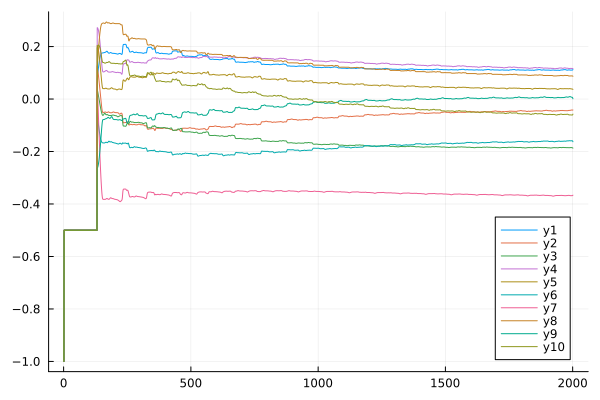

In [55]:
plot(ys0s[:,1,:]' |> cdev)

In [48]:
yp0 |> size

(10, 128)

In [49]:
y_spk_f, st_spk_f = spk_model(x0 |> gdev, ps_train_f, st_train_f)

(CuArray{Float32, 2, CUDA.DeviceMemory}[[-1.0 -1.0 … -1.0 -1.0; -1.0 -1.0 … -1.0 -1.0; … ; -1.0 -1.0 … -1.0 -1.0; -1.0 -1.0 … -1.0 -1.0], [-0.5 -0.5 … -0.5 -0.5; -0.5 -0.5 … -0.5 -0.5; … ; -0.5 -0.5 … -0.5 -0.5; -0.5 -0.5 … -0.5 -0.5], [-0.5 -0.5 … -0.5 -0.5; -0.5 -0.5 … -0.5 -0.5; … ; -0.5 -0.5 … -0.5 -0.5; -0.5 -0.5 … -0.5 -0.5], [-0.5 -0.5 … -0.5 -0.5; -0.5 -0.5 … -0.5 -0.5; … ; -0.5 -0.5 … -0.5 -0.5; -0.5 -0.5 … -0.5 -0.5], [-0.5 -0.5 … -0.5 -0.5; -0.5 -0.5 … -0.5 -0.5; … ; -0.5 -0.5 … -0.5 -0.5; -0.5 -0.5 … -0.5 -0.5], [-0.5 -0.5 … -0.5 -0.5; -0.5 -0.5 … -0.5 -0.5; … ; -0.5 -0.5 … -0.5 -0.5; -0.5 -0.5 … -0.5 -0.5], [-0.5 -0.5 … -0.5 -0.5; -0.5 -0.5 … -0.5 -0.5; … ; -0.5 -0.5 … -0.5 -0.5; -0.5 -0.5 … -0.5 -0.5], [-0.5 -0.5 … -0.5 -0.5; -0.5 -0.5 … -0.5 -0.5; … ; -0.5 -0.5 … -0.5 -0.5; -0.5 -0.5 … -0.5 -0.5], [-0.5 -0.5 … -0.5 -0.5; -0.5 -0.5 … -0.5 -0.5; … ; -0.5 -0.5 … -0.5 -0.5; -0.5 -0.5 … -0.5 -0.5], [-0.5 -0.5 … -0.5 -0.5; -0.5 -0.5 … -0.5 -0.5; … ; -0.5 -0.5 … -0.5 -0.5; -0.5

In [50]:
y_spk_s = y_spk_f |> stack |> cdev;

In [53]:
size(y_spk_s)

(10, 128, 2001)

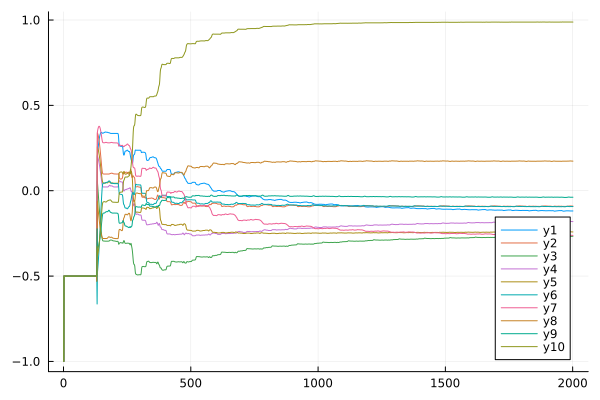

In [54]:
plot(y_spk_s[:,1,:]')

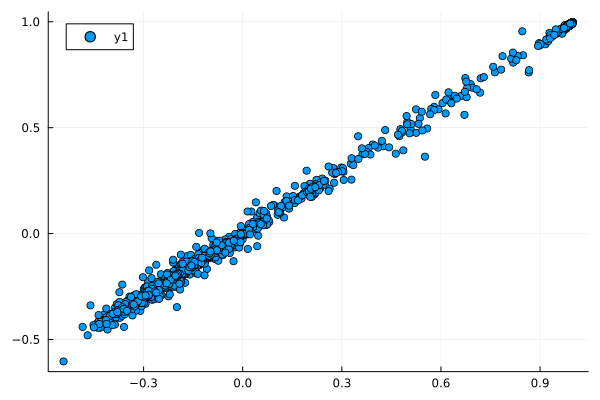

In [52]:
scatter(vec(cdev(yp1)), vec(y_spk_s[:,:,end]))

In [56]:
spk_inner = Chain(FlattenLayer(),
            LayerNorm((28^2,)),
            x -> tanh.(x), 
            MakeSpiking(spk_args, repeats),
            PhasorDense(28^2 => 128, soft_angle, init_bias=default_bias),
            PhasorDense(128 => 16, soft_angle, init_bias=default_bias),
            x -> x,
            )

Chain(
    layer_1 = FlattenLayer{Nothing}(nothing),
    layer_2 = LayerNorm((784,), affine=true, dims=Colon()),  # 1_568 parameters
    layer_3 = WrappedFunction(#38),
    layer_4 = MakeSpiking(Neuron parameters: Period 1.0 (s)
Current kernel duration: 0.01 (s)
Threshold: 0.001 (V)
, 20, (0.0f0, 20.0f0), 0.0f0),
    layer_5 = PhasorDense(
        layer = Dense(784 => 128, use_bias=false),  # 100_352 parameters
        bias = ComplexBias((128,)),               # 256 parameters
    ),
    layer_6 = PhasorDense(
        layer = Dense(128 => 16, use_bias=false),  # 2_048 parameters
        bias = ComplexBias((16,)),                # 32 parameters
    ),
    layer_7 = WrappedFunction(#39),
)         # Total: 104_256 parameters,
          #        plus 0 states.

In [57]:
y_spk_i, _ = spk_inner(x0 |> gdev, ps_train_f, st_train_f)

(SpikingCall(SpikeTrainGPU{2}(CartesianIndex{2}[CartesianIndex(1, 1), CartesianIndex(2, 1), CartesianIndex(3, 1), CartesianIndex(4, 1), CartesianIndex(5, 1), CartesianIndex(6, 1), CartesianIndex(7, 1), CartesianIndex(8, 1), CartesianIndex(9, 1), CartesianIndex(10, 1)  …  CartesianIndex(7, 128), CartesianIndex(8, 128), CartesianIndex(9, 128), CartesianIndex(10, 128), CartesianIndex(11, 128), CartesianIndex(12, 128), CartesianIndex(13, 128), CartesianIndex(14, 128), CartesianIndex(15, 128), CartesianIndex(16, 128)], [1, 2, 3, 4, 5, 6, 7, 8, 9, 10  …  2039, 2040, 2041, 2042, 2043, 2044, 2045, 2046, 2047, 2048], Float32[2.008596, 2.0108058, 2.0063984, 2.0052655, 2.0023444, 2.0049148, 2.0046887, 2.0117078, 2.007914, 2.0017514  …  21.002962, 21.497063, 20.509584, 20.99809, 20.508005, 20.989025, 20.998806, 20.500164, 21.00614, 20.999441], (16, 128), 2048, 0.5f0), Neuron parameters: Period 1.0 (s)
Current kernel duration: 0.01 (s)
Threshold: 0.001 (V)
, (0.0f0, 20.0f0)), (layer_1 = NamedTuple(

In [58]:
st3 = get_time(y_spk_i.train, (5.0, 10.0))

Spike Train: (16, 128) with 10244 spikes.

In [59]:
st3_b1 = st3[:,1:5]

Spike Train: (16, 5) with 400 spikes.

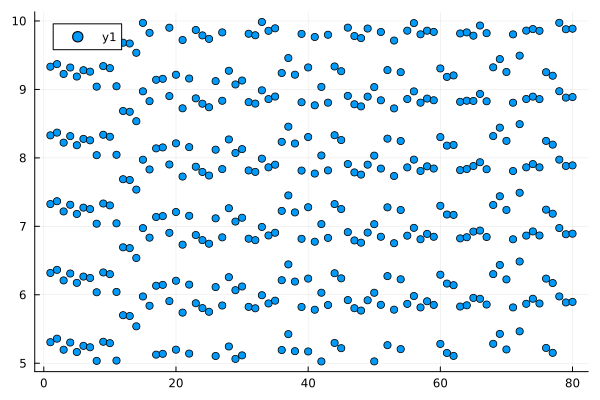

In [60]:
scatter(LinearIndices(st3_b1.shape)[st3_b1.indices], st3_b1.times) 

In [61]:
function test_phasor(model, data_loader, ps, st)
    # Evaluation phase
    total_correct = 0
    total_samples = 0
    for (x, y) in data_loader
        x = x |> gdev
        
        y_pred, _ = Lux.apply(model, x, ps, st)
        pred_labels = predict_codebook(cdev(y_pred))
        
        total_correct += sum(pred_labels .== y .+ 1)
        total_samples += length(y)
    end

    acc = total_correct / total_samples
end

test_phasor (generic function with 1 method)

In [62]:
ys0[end] |> size

(10, 128)

In [63]:
function fmnist_spiking_accuracy(data_loader, model, ps, st, args)
    correct = 0
    num = 0
    
    for (x, y) in data_loader
        if args.use_cuda && CUDA.functional()
            x = x |> gdev
        end
        
        sim_output, _ = model(x, ps, st)
        pred_labels = predict_codebook(cdev(sim_output[end]))

        correct += sum(pred_labels .== y .+ 1)
        num += length(y)
    end

    return correct/num
end

fmnist_spiking_accuracy (generic function with 1 method)

In [ ]:
spk_a = fmnist_spiking_accuracy(test_loader, spk_model, ps_train_f, st_train_f, args)